In [1]:
%pylab inline
import scipy.stats as stats

# do imports for bokeh
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models.mappers import LinearColorMapper,LogColorMapper,EqHistColorMapper


Populating the interactive namespace from numpy and matplotlib


# Exploring combining measurements

When we combine two measurements that have a different dependence on the underlying parameters with each other, we get a more constraining result: Fisher matrices (= inverse covariance matrices) from indepedent experiments add.

In [2]:
# let's set up 2 fake Fisher matrices, corresponding to orthogonal constraints
fish1=np.array([[1,-1],[-1,1]])  # Fisher matrix 1
fish2=np.array([[1,1],[1,1]])    # Fisher matrix 2


# Set up a grid of x and y values for each pixel of an output grid from -5 to 5 in each direction

nxy=101
xv= np.linspace(-5,5,nxy)
yv=np.copy(xv)


# meshgrid creates 2 2-d arrays, 
# one with the x value at each point in the image and the other the y value
x,y = np.meshgrid(xv,yv)

Below is code to display the `x` array via `bokeh`.  Explore and confirm that it looks as you would expect. __Then, using the following code box display the `y` array via `bokeh` and explore it.__

In [3]:

# put the plot in this notebook.  
# We only need to do this command once per notebook.
output_notebook()

# set up tooltips so we can read off values at the cursor
# We only need to run this code again when we change axis ranges.
p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")])
p.x_range.range_padding = p.y_range.range_padding = 0

# You could instead try the EqHistColorMapper
color_mapper = LinearColorMapper(palette="Turbo256", low=x.min(), high=x.max())

# set up the image display, with axis ranges from -5 to +5 
p.image(image=[y], x=-5, y=-5, dw=10, dh=10, level="image", \
         color_mapper=color_mapper)

# show the image, interactively
show(p)


Loading BokehJS ...

For a multivariate Gaussian $\ln{L}= -{1 \over 2} ({\bf x-\mu})^T {\bf C}^{-1} ({\bf x-\mu}) + K$, where K is a constant and x and __$\mu$__ are arrays: the 2 elements of the __x__ array correspond to our x and y variables here. So:

In [4]:
# Note: ll stands for 'log likelihood' here
ll1=-.5*(fish1[0,0]*x**2+fish1[1,0]*x*y+fish1[0,1]*x*y+fish1[1,1]*y**2)
ll2=-.5*(fish2[0,0]*x**2+fish2[1,0]*x*y+fish2[0,1]*x*y+fish2[1,1]*y**2)

__Using the below code boxes, explore the `ll1` and `ll2` arrays using bokeh__

In [5]:
if 1:
# You could instead try the EqHistColorMapper
     color_mapper = LinearColorMapper(palette="Turbo256", low=ll1.min(), high=ll1.max())

# set up the image display, with axis ranges from -5 to +5 
     p.image(image=[ll1], x=-5, y=-5, dw=10, dh=10, level="image", \
         color_mapper=color_mapper)

# show the image, interactively
     show(p)


In [6]:
if 1:

#Calculate alpha = 0.05 cutoff level for chi-squared distribution with 2 degrees of freedom
     signif = 0.05
     cutoff=stats.chi2.ppf(1-signif,2)

# To see where the log-likelihood from dataset 1 is below the cutoff:
     is_ok = (-2*ll1 < cutoff)*1.

# You could instead try the EqHistColorMapper
     color_mapper = LinearColorMapper(palette="Turbo256", low=-1, high=2)

# set up the image display, with axis ranges from -5 to +5 
     p.image(image=[is_ok], x=-5, y=-5, dw=10, dh=10, level="image",color_mapper=color_mapper)

# show the image, interactively
     show(p)



__Using the below code box, explore the combined constraint, i.e. `ll1+ll2`, using bokeh.  Explore the log-likelihood itself and then determine the shape of the region above the cutoff.__


In [7]:
if 1:

#Calculate alpha = 0.05 cutoff level for chi-squared distribution with 2 degrees of freedom
     signif = 0.05
     cutoff=stats.chi2.ppf(1-signif,2)

# To see where the log-likelihood from dataset 1 is below the cutoff:
     is_ok = (-2*(ll1+ll2) < cutoff)*1.

# You could instead try the EqHistColorMapper
     color_mapper = LinearColorMapper(palette="Turbo256", low=-1, high=2)

# set up the image display, with axis ranges from -5 to +5 
     p.image(image=[is_ok], x=-5, y=-5, dw=10, dh=10, level="image",color_mapper=color_mapper)

# show the image, interactively
     show(p)

# Applying maximum likelihood to a previous problem

Let's try finding a better solution for part 2 of HW 3, measuring the velocity dispersion of a galaxy cluster with outliers.  First, we set up Monte Carlo simulations as before.  __Make sure you can explain why the histogram looks the way it does, based on the code below!__

Text(0.5, 0, '$v \\,(km ~s^{-1})$')

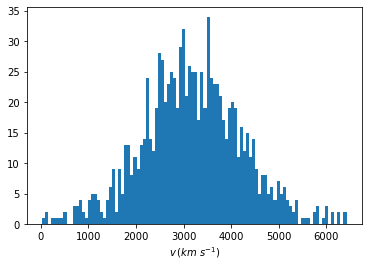

In [8]:
import numpy.random as random

ndata=int(1E3)
foutlier=0.1
z0=3150.
isoutlier=random.rand(ndata) < foutlier
zdist=(1-isoutlier)*(random.randn(ndata)*930.+z0) + (isoutlier)*random.rand(ndata)*6500

n,bins,patches=plt.hist(zdist,bins=100)
plt.xlabel(r'$v \,(km ~s^{-1})$')


We can solve the problem either by calculating the product of the likelihoods from each measurement, or the sum of the log-likelihoods; e.g.

`p = np.product( (1-foutlier)*1/np.sqrt(2.*np.pi*sigma**2)*np.exp(-(zdist-z0)**2/2/sigma**2 ) + foutlier*(1./6500.))`

or 

`LL = np.sum( np.log((1-foutlier)*1/np.sqrt(2.*np.pi*sigma**2)*np.exp(-(zdist-z0)**2/2/sigma**2 ) + foutlier*(1./6500.)))`

The latter is more numerically stable so we will do that.

First, we set up a grid of foutlier & sigma values, then evaluate the log-likelihood:

In [9]:
nf=101
nsigma=101
foutlier = np.linspace(0,0.25,101)
sigma = np.linspace(700,1200,101)

In [10]:
# create an array for the log-likelihoods
LL = np.zeros((nf,nsigma))

In [11]:
# We loop over all the pixels in the grid of sigma/foutlier values
# and evaluate the log likelihood at each point:

for i in np.arange(nsigma):
    for j in np.arange(nf):
        LL[j,i] = np.sum( np.log((1-foutlier[j])*1/np.sqrt(2.*np.pi*sigma[i]**2) \
         *np.exp(-(zdist-z0)**2/2/sigma[i]**2 ) +
            foutlier[j]*(1./6500.)))


## Checking that we have a maximum:

### a) by examining the grid in 2D

In the below code box, we subtract off the maximum likelihood value to get something that peaks at 0.  

__Explore in `bokeh` and find the [i,j] coordinates of the peak, i.e., where the value of the array is zero.__

In [12]:
if 1:
    LL=LL-np.max(LL)

# we need to reinitialize this as our axes will be different from before
    p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")])
    p.x_range.range_padding = p.y_range.range_padding = 0


# You could instead try the LinearColorMapper
    color_mapper = EqHistColorMapper(palette="Turbo256", low=LL.min(), high=LL.max())

# set up the image display, with axis ranges 
#   covering the range of foutlier and sigma
    p.image(image=[LL], x=foutlier.min(), y=sigma.min(), \
        dw=(foutlier.max()-foutlier.min()), dh=(sigma.max()-sigma.min()), \
        level="image",color_mapper=color_mapper)

# show the image, interactively
    show(p)



The below code returns the pixel coordinates of the maximum -- hopefully it agrees with your value (after accounting for the fact that the y index is listed before the x index in Python).

In [21]:
#where is the maximum?
yloc,xloc = numpy.unravel_index(LL.argmax(), LL.shape)

print(f'x,y indices of maximum likelihood point: {xloc},{yloc}')
print(f'maximum likelihood foutlier: {foutlier[yloc]}')
print(f'maximum likelihood sigma: {sigma[xloc]}')


x,y indices of maximum likelihood point: 47,35
maximum likelihood foutlier: 0.08750000000000001
maximum likelihood sigma: 935.0


### b) by looking at LL around the expected maximum

We can check that the expected coordinates should be (40,46) for the right answer:

In [14]:
print(f'foutlier and sigma at nominal coordiantes: {foutlier[40]},{sigma[46]}')

foutlier and sigma at nominal coordiantes: 0.1,930.0


We therefore plot row 40 or column 46 of the grid; this should hopefully correspond to somewhere near the peak and allow us to coarsely assess whether we've found a global maximum.

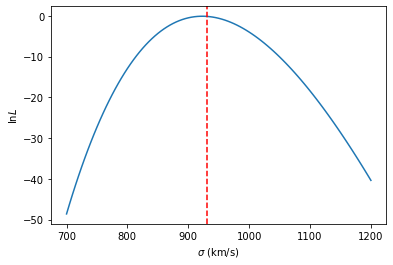

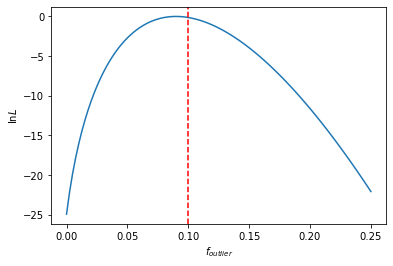

In [22]:
if 1:
    plt.figure(1)
    plt.plot(sigma,LL[40,:])
    plt.xlabel(r'$\sigma$ (km/s)')
    plt.ylabel(r'$\ln{L}$')
    plt.axvline(x=930,ls='--',color='red')

    plt.figure(2)
    plt.plot(foutlier,LL[:,46])
    plt.axvline(x=0.10,ls='--',color='red')
    plt.xlabel(r'$f_{outlier}$')
    plt.ylabel(r'$\ln{L}$')

### c) by looking at the marginalized probability distributions

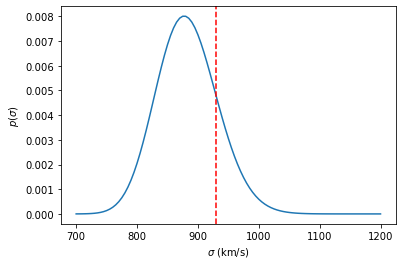

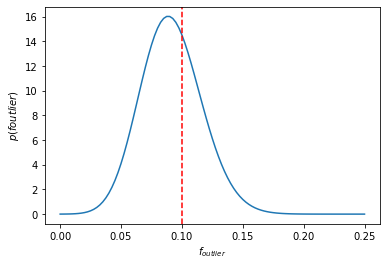

In [24]:
if 1:
    plt.figure(1)

# normalize to plot the actual p(sigma)
    p_of_sigma = np.sum(np.exp(LL),axis=1)

# normalize to have integral one
    p_of_sigma = p_of_sigma/np.sum(p_of_sigma)/(sigma[1]-sigma[0])

    plt.plot(sigma,p_of_sigma )
    plt.xlabel(r'$\sigma$ (km/s)')
    plt.ylabel(r'$p(\sigma)$')
    plt.axvline(x=930,ls='--',color='red')

# normalize to plot the actual p(f)
    p_of_f = np.sum(np.exp(LL),axis=1)
# normalize to have integral one
    p_of_f = p_of_f/np.sum(p_of_f)/(foutlier[1]-foutlier[0])

    plt.figure(2)
    plt.plot(foutlier,p_of_f )

    plt.axvline(x=0.10,ls='--',color='red')
    plt.xlabel(r'$f_{outlier}$')
    plt.ylabel(r'$p(f{{outlier}})$')

### d) By looking at the contours of -2*(log likelihood)

We plot here 68%, 95%, and 99% confidence contours: regions that should contain the true value 68/95/99% of the time.

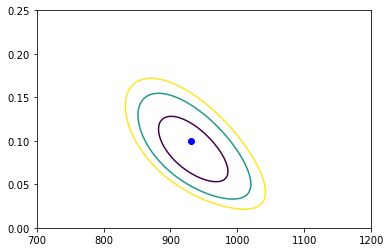

In [30]:
if 1:
    plt.contour(sigma,foutlier,-2*LL, \
            levels=[stats.chi2.ppf(1-0.32,2), \
                    stats.chi2.ppf(1-0.05,2),stats.chi2.ppf(1-0.01,2)])

# plot the true value: is it inside our 68%, 95% and/or 99% contour?
    plt.plot(930,0.1,'bo')

# More things to do

__1) Run multiple times (use 'Run all' in the Cell menu) and see how the map of likelihood across the (foutlier, sigma) plane changes.__

__2) Revise the code to use 100 galaxies instead of 1E3.   Run several times.__

__3) Now try 1E4 galaxies instead of 1E3.  Run.__

__What do we see?__


## If you have extra time

__Try fitting for z0 and sigma, while keeping foutlier fixed.__